In [70]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

import matplotlib.pyplot as plot
import numpy as np
from numpy import genfromtxt
import csv
import sys, os, re
import pathlib

print(tf.__version__)

2.0.0


In [71]:
# The CANlab/WAVi Pain Study is Pre-Formatted to resemble BIDS neuroimaging formatting
# If your study does not abide to the following structure, please revisit previous scripts
# .../StudyRepo
# -------------> /raw
# -------------------> /*.art
# -------------------> /*.eeg
# -------------------> /*.evt
# -------------> /contigs
# -------------------> /train          2:1 train:test
# -------------------> /test

In [60]:
if "contigs" not in os.getcwd():
    try:
        os.chdir("CANlabStudy/contigs")
        directory=os.getcwd()
    except:
        print("I couldn't find the contigs folder.\n")
        directory = input("Please give the full path of the contigs folder: ")
        os.chdir(directory)

In [61]:
#train_path = pathlib.Path('train/p300/')
train_path = pathlib.Path('train/chronic/')
#train_path = pathlib.Path('train/')

# test_path = pathlib.Path('test/p300/')
test_path = pathlib.Path('test/chronic/')
#test_path = pathlib.Path('test/')

In [62]:
# load in image paths for training set

import random

train_image_paths = os.listdir(train_path)
#train_image_paths = list(train_path.glob('*/*'))
train_image_paths = [str(path) for path in train_image_paths]
random.shuffle(train_image_paths)

train_count = len(train_image_paths)
print("You have", train_count, "training images.")

# load in image paths for testing set?

test_image_paths = os.listdir(test_path)
#test_image_paths = list(test_path.glob('*/*'))
test_image_paths = [str(path) for path in test_image_paths if "ctrl" in path]
random.shuffle(test_image_paths)

test_count = len(test_image_paths)
print("You have", test_count, "testing images.")

You have 2580 training images.
You have 515 testing images.


In [63]:
#list the available labels
label_names = ['ctrl', 'pain']
#label_names = sorted(item.name for item in train_path.glob('*/') if item.is_dir())
print("Labels discovered:", label_names)

Labels discovered: ['ctrl', 'pain']


In [64]:
#assign an index to each label
label_to_index = dict((name, index) for index, name in enumerate(label_names))
print("Label indices:", label_to_index)

Label indices: {'ctrl': 0, 'pain': 1}


In [145]:
#create a list of every file and its index label

train_image_labels = [label_to_index[path[:4]] for path in train_image_paths]
#train_image_labels = [label_to_index[pathlib.Path(path).parent.name]
 #                   for path in train_image_paths]
# force list of strings to numpy array
train_image_labels = np.array(train_image_labels)
    
    
test_image_labels = [label_to_index[path[:4]] for path in test_image_paths]    
#test_image_labels = [label_to_index[pathlib.Path(path).parent.name]
 #                   for path in test_image_paths]
# force list of strings to numpy array
test_image_labels = np.array(test_image_labels)

In [179]:
def norm_array(array):
    return((array - np.min(array)) / np.ptp(array))

In [184]:
def load_numpy_stack(lead, paths):
    numpy_stack = []
    for path in paths:
        path = lead+path
        array = genfromtxt(path, delimiter=",")
        #row_sums = array.sum(axis=0, keepdims=True)
        #norm_array = array / row_sums
        #array = norm_array(array)
        array = array.reshape(array.shape +(1,))
        numpy_stack.append(array)
    numpy_dataset = np.rollaxis(np.block(numpy_stack), 2, 0)
    numpy_dataset = numpy_dataset.reshape(numpy_dataset.shape+(1,))
    return(numpy_dataset)

In [185]:
train_arrays = load_numpy_stack('train/chronic/', train_image_paths)
#train_arrays = load_numpy_stack('', train_image_paths)

test_arrays = load_numpy_stack('test/chronic/', test_image_paths)
#test_arrays = load_numpy_stack('', test_image_paths)

In [220]:
def createModel(learn, num_epochs):
    # Introduce sequential Set
    model = tf.keras.models.Sequential()
    
    # Create a convolutional base
    model.add(tf.keras.layers.Conv2D(5, kernel_size=6, strides=6, padding='same', activation='relu', data_format='channels_last', use_bias=False))    
    model.add(tf.keras.layers.Conv2D(5, kernel_size=6, strides=6, padding='same', activation='relu', data_format='channels_last', use_bias=False))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format=None))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Conv2D(5, kernel_size=6, strides=6, padding='same', activation='relu', data_format='channels_last', use_bias=False))
    model.add(tf.keras.layers.Conv2D(5, kernel_size=6, strides=6, padding='same', activation='relu', data_format='channels_last', use_bias=False))
    #model.add(tf.keras.layers.Conv2D(5, kernel_size=5, strides=5, padding='same', activation='relu', data_format='channels_last', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
    
    # Layers
    #model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=None, padding='same', data_format=None))
    model.add(tf.keras.layers.Flatten(data_format="channels_last"))   
    
    # Hidden layers
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    
    model.build(train_arrays.shape)
    model.summary()
    
    # Model compilation
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learn),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    history = model.fit(train_arrays, train_image_labels, epochs=num_epochs,
                       validation_data=(test_arrays, test_image_labels))
    
    return(history)

What's my learning rate? 0.001
How many epochs? 100
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_133 (Conv2D)          multiple                  180       
_________________________________________________________________
conv2d_134 (Conv2D)          multiple                  900       
_________________________________________________________________
max_pooling2d_26 (MaxPooling multiple                  0         
_________________________________________________________________
dropout_35 (Dropout)         multiple                  0         
_________________________________________________________________
conv2d_135 (Conv2D)          multiple                  900       
_________________________________________________________________
conv2d_136 (Conv2D)          multiple                  900       
_________________________________________________________________
b

Epoch 44/100
2580/2580 [==============================] - 1s 464us/sample - loss: 0.3893 - accuracy: 0.8112 - val_loss: 0.7606 - val_accuracy: 0.5883
Epoch 45/100
2580/2580 [==============================] - 1s 465us/sample - loss: 0.3924 - accuracy: 0.8194 - val_loss: 0.8352 - val_accuracy: 0.5379
Epoch 46/100
2580/2580 [==============================] - 1s 440us/sample - loss: 0.4071 - accuracy: 0.8140 - val_loss: 0.6066 - val_accuracy: 0.6835
Epoch 47/100
2580/2580 [==============================] - 1s 447us/sample - loss: 0.3960 - accuracy: 0.8194 - val_loss: 0.6174 - val_accuracy: 0.6854
Epoch 48/100
2580/2580 [==============================] - 1s 459us/sample - loss: 0.3945 - accuracy: 0.8217 - val_loss: 0.6495 - val_accuracy: 0.6466
Epoch 49/100
2580/2580 [==============================] - 1s 454us/sample - loss: 0.3777 - accuracy: 0.8271 - val_loss: 0.6632 - val_accuracy: 0.6718
Epoch 50/100
2580/2580 [==============================] - 1s 455us/sample - loss: 0.3810 - accuracy:

2580/2580 [==============================] - 2s 927us/sample - loss: 0.3013 - accuracy: 0.8628 - val_loss: 0.6412 - val_accuracy: 0.7126
Epoch 99/100
2580/2580 [==============================] - 2s 806us/sample - loss: 0.2966 - accuracy: 0.8674 - val_loss: 1.0530 - val_accuracy: 0.5320
Epoch 100/100
2580/2580 [==============================] - 2s 902us/sample - loss: 0.3085 - accuracy: 0.8636 - val_loss: 0.7574 - val_accuracy: 0.6621


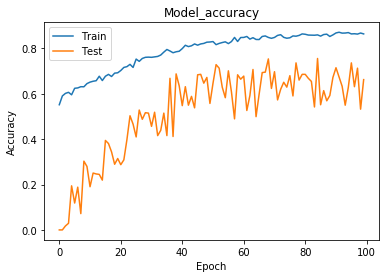

In [221]:
rates = np.arange(0.01, 0.1, 0.01)
beta1s = np.arange(0.9, 0.99, 0.01)
beta2s = np.arange(0.99, 0.999, 0.001)

rate = float(input("What's my learning rate? "))
epochs = int(input("How many epochs? "))

# compiled = kerasModel(rate)
# fitted = fitModel(compiled, epochs)
fitted = createModel(rate, epochs)

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(fitted.history['accuracy'])
plt.plot(fitted.history['val_accuracy'])
plt.title('Model_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#results = testModel(fitted)
#myresults.append(results)

In [117]:
myresults

# print("Loss: ", results[0], "\nAccuracy: ", results[1])

[[0.22637348339475435, 0.9122222], [0.3669460266828537, 0.8705556]]